### Import Dependencies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from flask import Flask, jsonify

### Reflect Tables into SQLAlchemy ORM


In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Instructions/Resources/hawaii.sqlite")
conn = engine.connect()

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Exploratory Climate Analysis

In [11]:
# viewing column names

inspector = inspect(engine)
inspector.get_table_names()
columns_measurement = inspector.get_columns('measurement')
columns_station = inspector.get_columns('station')

print("MEASUREMENT COLUMNS")
print('___________________')   
for column in columns_measurement:    
    print(column["name"], column["type"])
print('')   
print("STATION COLUMNS")
print('_______________')   
for column in columns_station:   
    print(column["name"], column["type"])

MEASUREMENT COLUMNS
___________________
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

STATION COLUMNS
_______________
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


## Design a query to retrieve the last 12 months of precipitation data and plot the results

### Perform a query to retrieve the data and precipitation scores

In [12]:
# Identify Last Date, so you can find 1 year earlier

results = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp,Measurement.tobs).\
    order_by(Measurement.date.desc()).all()

# Calculate the date 1 year ago from the last data point in the database
last_date = [result[2] for result in results[:1]]
last_day = dt.datetime.strptime(last_date[0], "%Y-%m-%d")
one_year = dt.timedelta(days=365)
year_ago = last_day - one_year

last_year = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp,Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()



## SIDE QUEST: Vewing the filterd Data as printed text

In [13]:
first_measure = [result[0:5] for result in last_year[:1]]
last_day_measure = [result[0:5] for result in results[:1]]
print('')
print('Initial Report')
print('______________')

first_date  = [date[2] for date in last_year[:1]]
print(f'First Measurement: {first_measure}')
print(f'Final Measurement: {last_day_measure}')
print(f'First Date: {year_ago}')
print(f'Last Date: {last_day}')

print('')
print(f'Observation View (Last 10)')
print('_______________________________________')
print('ID   | Station   | Date     |Prcp|T Obs')
print('---------------------------------------')
for reading in last_year:
    if reading.id > 19540:
        print(reading.id, reading.station, reading.date, reading.prcp, reading.tobs)


Initial Report
______________
First Measurement: [(2365, 'USC00519397', '2016-08-24', 0.08, 79.0)]
Final Measurement: [(2724, 'USC00519397', '2017-08-23', 0.0, 81.0)]
First Date: 2016-08-23 00:00:00
Last Date: 2017-08-23 00:00:00

Observation View (Last 10)
_______________________________________
ID   | Station   | Date     |Prcp|T Obs
---------------------------------------
19541 USC00516128 2017-08-14 0.22 79.0
19542 USC00516128 2017-08-15 0.42 70.0
19543 USC00516128 2017-08-16 0.42 71.0
19544 USC00516128 2017-08-17 0.13 72.0
19545 USC00516128 2017-08-18 None 76.0
19546 USC00516128 2017-08-19 0.09 71.0
19547 USC00516128 2017-08-20 None 78.0
19548 USC00516128 2017-08-21 0.56 76.0
19549 USC00516128 2017-08-22 0.5 76.0
19550 USC00516128 2017-08-23 0.45 76.0


In [14]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
# Save the query results as a Pandas DataFrame and set the index to the date column

last_year_prcp = pd.DataFrame(last_year)
last_year_prcp.dropna(inplace=True)
annual_analysis = last_year_prcp.rename(columns = {'prcp':'Precipitation'})
annual_analysis.drop(columns=['id','station','tobs'], inplace=True)
annual_analysis.set_index('date', inplace=True)
annual_analysis.to_sql(name='precipitation', con=engine, if_exists='replace', index_label='date')
precipitation = annual_analysis.groupby(level='date').mean()
precipitation.rename(columns = {'Precipitation':'Avg_Daily_Prcp'}, inplace=True)
print('Table 1. First 15 Readings\nTable 2. Most recent 15 Readings\nTable 3. Start of Year Avg Daily Precipitation\nTable 4. End of Year Avg Daily Precipitation')
display_side_by_side(annual_analysis.head(15),annual_analysis.tail(15), precipitation.head(15),precipitation.tail(15))
display_side_by_side()

Table 1. First 15 Readings
Table 2. Most recent 15 Readings
Table 3. Start of Year Avg Daily Precipitation
Table 4. End of Year Avg Daily Precipitation


,Precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08
2016-08-25,0.00


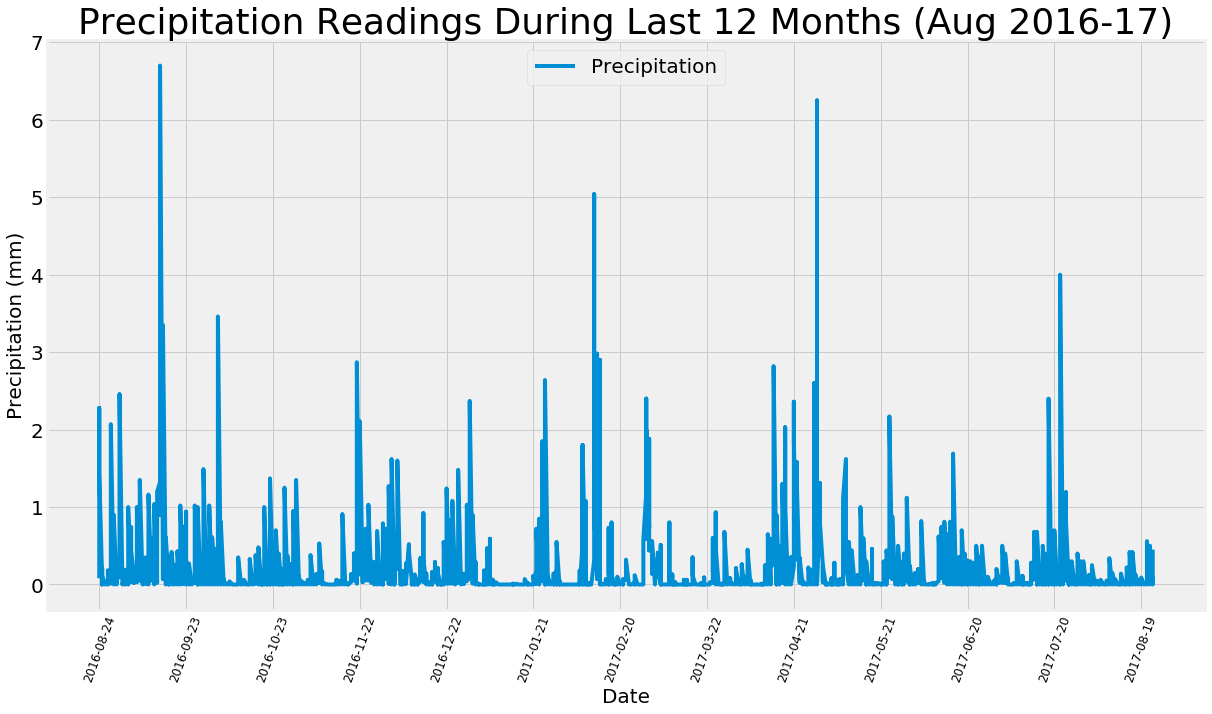

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(annual_analysis.index, annual_analysis['Precipitation'])
plt.title('Precipitation Readings During Last 12 Months (Aug 2016-17)', fontsize=36)
plt.xlabel('Date', fontsize=20)
plt.xticks(np.arange(0, 365, 30), rotation=70, fontsize=12)
plt.yticks(fontsize=20)
plt.ylabel('Precipitation (mm)', fontsize=20)
plt.legend(loc=9, prop={'size': 20})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('prcp_readings.png', dpi=100)
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
annual_analysis.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis
## --------------------------------------

#### Design a query to show how many stations are available in this dataset?

In [17]:
num_stations = session.query(Measurement.station).distinct().count()
print(f'SQLAlchemy says: {num_stations}')

print('')

results = pd.DataFrame(results)
pandas_count = results['station'].nunique()
print(f'Pandas says: {pandas_count}')

SQLAlchemy says: 9

Pandas says: 9


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
print('SQLAlchemy says:')

num_stations = session.query(Measurement.station, func.count(Measurement.id))\
                .group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
display(num_stations)
print(f'The Station with the most observations, follwed by total observations, is: {num_stations[0]}')

print('')
# List the stations and the counts in descending order.
print('Pandas says:')
top_stations = results.drop(columns=['prcp','date','tobs'])
top_stations.groupby(['station']).count().sort_values(['id'], ascending=False)

SQLAlchemy says:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

The Station with the most observations, follwed by total observations, is: ('USC00519281', 2772)

Pandas says:


,id
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


### Using the station id from the previous query, calculate 
* (1) the lowest temperature recorded, 
* (2) highest temperature recorded, and 
* (3) average temperature at the most active station?


#### (1) the lowest temperature recorded at the most active station

In [19]:
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
display(lowest_temp)

lowest_temp_record = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
display(lowest_temp_record)

[(54.0)]

[(13294, 'USC00519281', '2013-01-16', 0.02, 54.0)]

#### (2) highest temperature recorded

In [20]:
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
display(highest_temp)

highest_temp_record = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
display(highest_temp_record)

[(85.0)]

[(14261, 'USC00519281', '2015-09-10', 0.09, 85.0)]

#### (3) average temperature at the most active station?

In [21]:
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
display(avg_temp)

avg_temp_record = session.query(Measurement.id, Measurement.station, Measurement.date, func.avg(Measurement.prcp), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
display(avg_temp_record)

[(71.66378066378067)]

[(12188, 'USC00519281', '2010-01-01', 0.2123520923520915, 71.66378066378067)]

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [23]:
print('SQLAlchemy says:')
active_station_last_year = session.query(Measurement.date, Measurement.tobs)\
                                        .filter(Measurement.date >= year_ago)\
                                        .filter(Measurement.station == 'USC00519281')\
                                        .filter(Measurement.tobs.isnot(None))\
                                        .order_by(Measurement.date).all()
display(active_station_last_year[0:10])

print('Pandas says:')
asly_temp_obs = pd.DataFrame(np.array(active_station_last_year), columns=(["date","temp_obs"]))

asly_temp_obs.temp_obs = asly_temp_obs.temp_obs.astype(float)
asly_temp_obs.head(10)

SQLAlchemy says:


[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0)]

Pandas says:


,date,temp_obs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
5,2016-08-29,78.0
6,2016-08-30,77.0
7,2016-08-31,78.0
8,2016-09-01,80.0
9,2016-09-02,80.0


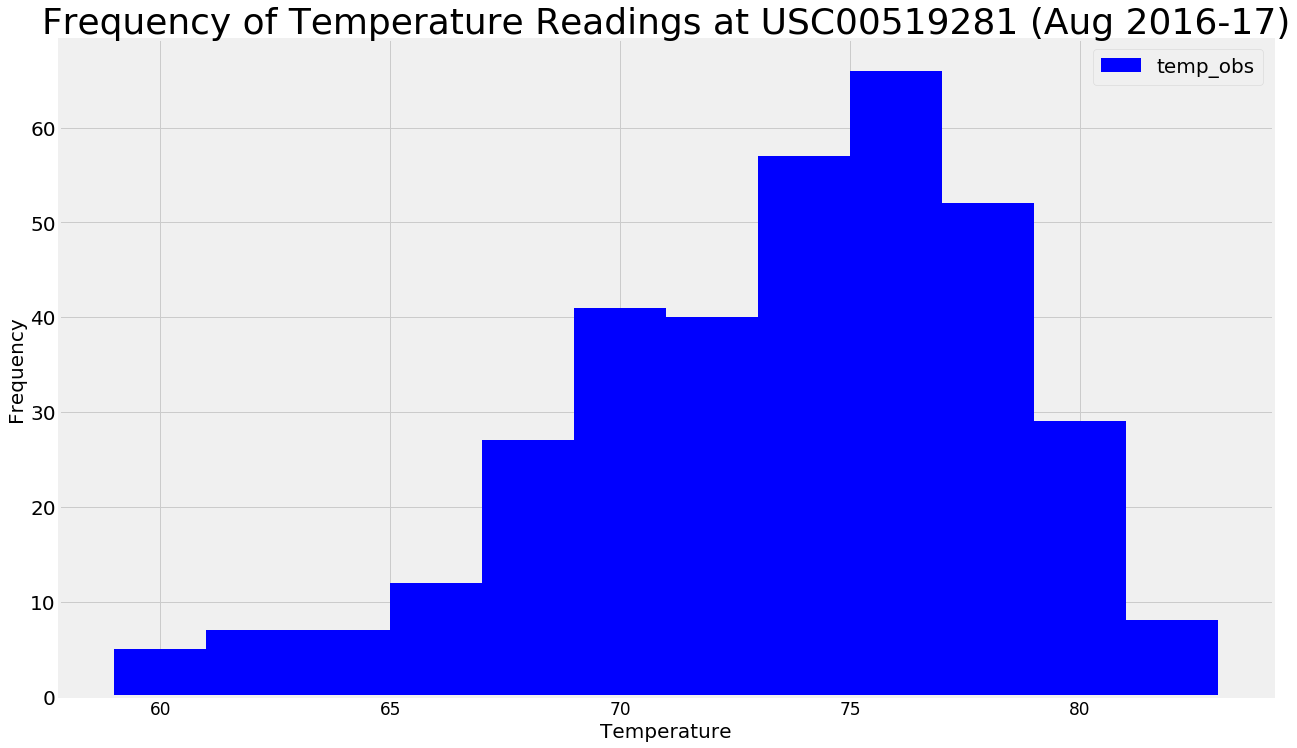

In [24]:
asly_temp_obs.plot.hist(by=None, bins=12, figsize=(15, 13), color="blue", fontsize=17)

plt.title('Frequency of Temperature Readings at USC00519281 (Aug 2016-17)', fontsize=36)
plt.xlabel('Temperature', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.legend(loc='best', prop={'size': 20})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.tight_layout()
plt.savefig("temp_obs_histogram.png")

## Step 2 - Climate App

* Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.
* Use FLASK to create your routes.

In [25]:
annual_analysis.head()

,Precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
